In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging
from experiments.util import lp_metric_dict
import numpy as np
from experiments.dbconnection import DBConnector

Using TensorFlow backend.


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc"]
DATASET = datasets[3]
learning_problem = "discrete_choice"
results_table = 'results.{}'.format(learning_problem)
schema = 'masterthesis'
start=3
select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"

In [3]:
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)

In [4]:
update_result = "UPDATE results.discrete_choice set cluster_id = %s, CategoricalAccuracy = %s, CategoricalTopK2 = %s, CategoricalTopK3 = %s, CategoricalTopK4 = %s, CategoricalTopK5 = %s, CategoricalTopK6 = %s  where job_id= %s"
values = (6636228, 0.4343, 0.6603, 0.8295, 0.9504, 1.0000, 1.0000,479)
self.init_connection()
self.cursor_db.execute(update_result, tuple(values))
self.close_connection()

In [5]:
def get_letor_string(dp):
    y =  str(dp['year']) 
    n = str(dp['n_objects'])
    return "y_{}_n_{}".format(y,n)

In [6]:
keys = list(lp_metric_dict[learning_problem].keys())
keys[-1] = keys[-1].format(6)
metrics = ', '.join([x for x in keys])
metrics

'CategoricalAccuracy, CategoricalTopK2, CategoricalTopK3, CategoricalTopK4, CategoricalTopK5, CategoricalTopK6'

In [7]:
self.init_connection()
avail_jobs = "{}.avail_jobs".format(self.schema)
select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
print(select_st)
self.cursor_db.execute(select_st)
data = []
for job in self.cursor_db.fetchall():
    job = dict(job)
    n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
    if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
        job['learner'] = job['learner']+'_shallow'
    elif n_hidden==[1,4] or n_hidden==[1,5]:
        job['learner'] = job['learner']+'_shallow'
        
    if job['learner_params'].get("add_zeroth_order_model", False):
        job['learner'] = job['learner']+'_zero'
    if "letor" in job['dataset']:
        job['dataset'] = get_letor_string(job['dataset_params'])
    elif "sushi" in job['dataset']:
        job['dataset'] =  job['dataset']
    else:
        job['dataset'] = job['dataset_params']['dataset_type']
    job['learner'] = job['learner'].upper()
    job['dataset'] = job['dataset'].upper()
    values = list(job.values())
    keys = list(job.keys())
    columns = keys[start:]
    vals = values[start:]
    data.append(vals)

SELECT learner_params, dataset_params, hp_ranges, results.discrete_choice.job_id, dataset, learner, CategoricalAccuracy, CategoricalTopK2, CategoricalTopK3, CategoricalTopK4, CategoricalTopK5, CategoricalTopK6 from results.discrete_choice INNER JOIN masterthesis.avail_jobs ON results.discrete_choice.job_id = masterthesis.avail_jobs.job_id where masterthesis.avail_jobs.dataset='letor_dc'


In [8]:
self.init_connection()
avail_jobs = "{}.avail_jobs".format("pymc3")
select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
print(select_st)
self.cursor_db.execute(select_st)
for job in self.cursor_db.fetchall():
    job = dict(job)
    if "letor" in job['dataset']:
        job['dataset'] = get_letor_string(job['dataset_params'])
    elif "sushi" in job['dataset']:
        job['dataset'] =  job['dataset']
    else:
        job['dataset'] = job['dataset_params']['dataset_type']
    job['learner'] = job['learner'].upper()
    job['dataset'] = job['dataset'].upper()
    values = list(job.values())
    keys = list(job.keys())
    columns = keys[start:]
    vals = values[start:]
    data.append(vals)
df_full = pd.DataFrame(data, columns=columns)

SELECT learner_params, dataset_params, hp_ranges, results.discrete_choice.job_id, dataset, learner, CategoricalAccuracy, CategoricalTopK2, CategoricalTopK3, CategoricalTopK4, CategoricalTopK5, CategoricalTopK6 from results.discrete_choice INNER JOIN pymc3.avail_jobs ON results.discrete_choice.job_id = pymc3.avail_jobs.job_id where pymc3.avail_jobs.dataset='letor_dc'


In [9]:
df_full = df_full.sort_values('dataset')
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']
df_full.loc[df_full['learner'] == 'GENERALIZED_EXTREME_VALUE']
#df_full.head()
del df_full['job_id']

In [10]:
from constants import DCMS
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode Least Angle"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
data = []
dataf = []
for dataset, dgroup in df_full.groupby(['dataset']):
    maxval = -100
    feta_r = []
    for learner, group in dgroup.groupby(['learner']):
        one_row = [dataset, learner]
        std = group.std(axis=0).values
        mean = group.mean(axis=0).values
        if np.all(np.isnan(std)):
            one_row.extend(["{:.4f}".format(m) for m in mean])
            #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
        else:
            #std = [s*1e3 for s in std]
            one_row.extend(mean)
            #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
        if "FETA" in str(learner):
            if maxval < mean[0]-std[0]:
                maxval = mean[0]-std[0]
                feta_r = one_row
                feta_r[1] = "FETA_DC"
        else:
            data.append(one_row)
    data.append(feta_r)
df = pd.DataFrame(data, columns=columns[1:])
df.sort_values(by='dataset')
df.head()

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,Y_2007_N_10,FATE_DC,0.23142,0.36780,0.47710,0.57416,0.65620,0.73518
1,Y_2007_N_10,FATE_DC_SHALLOW,0.24990,0.38534,0.49998,0.60218,0.68964,0.76540
2,Y_2007_N_10,GENERALIZED_EXTREME_VALUE,0.29464,0.44872,0.56616,0.66660,0.75150,0.81504
3,Y_2007_N_10,MIXED_LOGIT_MODEL,0.24628,0.38012,0.49158,0.58784,0.67918,0.76214
4,Y_2007_N_10,MULTINOMIAL_LOGIT_MODEL,0.28682,0.44212,0.56622,0.66786,0.75254,0.81804


In [13]:
def plot_group(grouped, plot_file, size, cols):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=True, frameon=True, edgecolor='k', facecolor='white')
    fig.subplots_adjust(hspace=0)
    for i, group in enumerate(grouped):
        name, group = group[0], group[1]
        dataFrame = group.set_index('learner').T
        try:
            sub_plot = axs[i]
        except Exception:
            sub_plot = axs
        for learner, model in zip(DCMS,models):
            if learner in list(dataFrame.columns):
                acc = dataFrame[learner].as_matrix()[1:]
                sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker="o")
        sub_plot.set_yticks(np.arange(mini,maxi+0.1,0.05))
        sub_plot.set_xlabel(x_label)
        if i == 0:
            sub_plot.set_ylabel(y_label)
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
                #maxi, mini = get_max_min(maxi, mini, acc)
    plt.xticks(N_OBJECTS_ARRAY)
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white',framealpha=0.1, edgecolor='k')
    plt.savefig(plot_file, facecolor='w', edgecolor='w',transparent=False, dpi=800,format='pdf',bbox_inches = 'tight', pad_inches = 0)
    plt.tight_layout()
    plt.show()

/home/pritha/git/2018-choice-functions/experiments/thesis/letor{}.pdf
dict_keys(['Y_2007_N_10', 'Y_2007_N_5', 'Y_2008_N_10', 'Y_2008_N_5'])


<IPython.core.display.Javascript object>


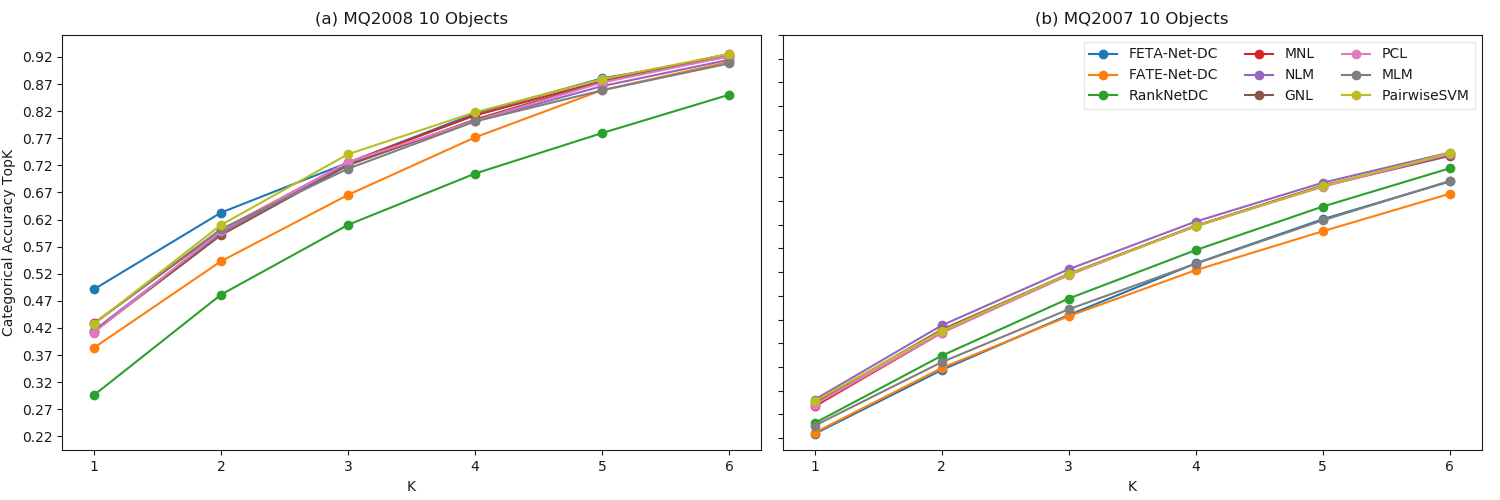

<IPython.core.display.Javascript object>


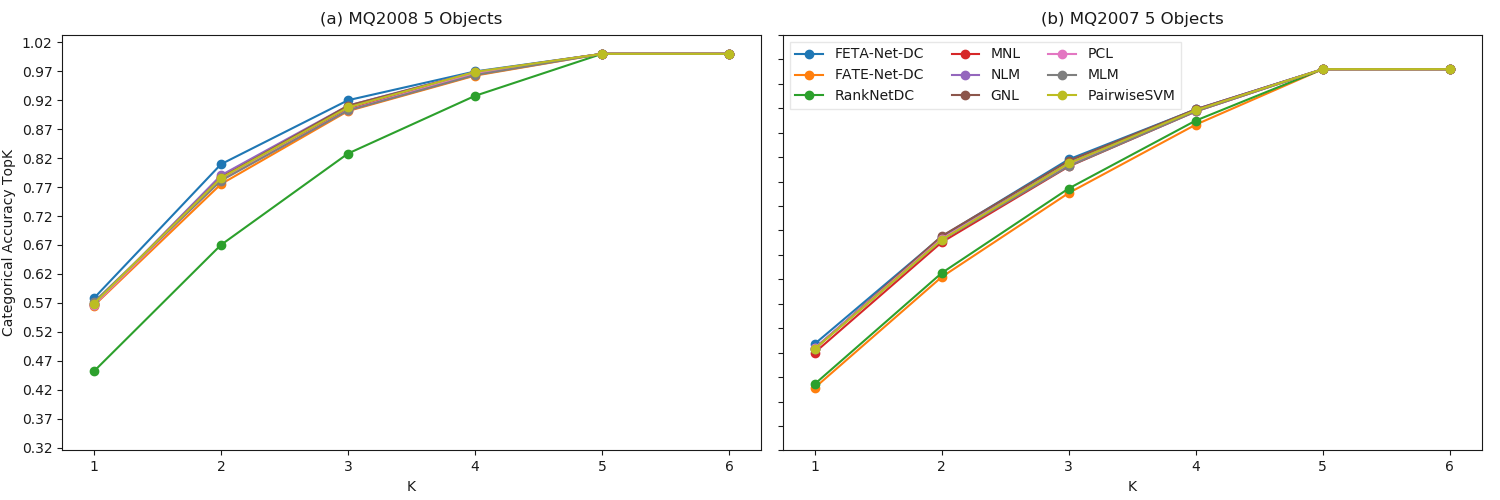

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
#sns.set_style("dark")
y_label="Categorical Accuracy TopK"
x_label="K"
plot_file = os.path.join(DIR_PATH, 'thesis', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
print(plot_file)
grouped = df.groupby(['dataset'])
print(grouped.groups.keys())
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
DCMS = [d.upper() for d in DCMS]
N_OBJECTS_ARRAY = np.arange(6) + 1
maxi = np.around(np.max(df.as_matrix()[:,2:]),2)
mini = np.around(np.min(df.as_matrix()[:,2:]),2)
i = 0
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
if len(grouped)==4:
    a = 1
    b = 2
    size = (15,5)
if len(grouped)==3 or len(grouped)==6:
    a = 1
    b = 3
    size = (18,5)
if len(grouped)==1:
    a = 1
    b = 1
    size = (8,5)
ns = int(len(grouped)/b)

if ns == 1:
    ns = len(grouped)
    plot_files = [plot_file.format('')]
else:
    plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]

groups = np.array([group for group in grouped])
dict_inds = {'synthetic_dc':  [[0,1,2]], 'mnist_dc': [[2,0], [3,1]], 'tag_genome_dc':[[0,1,5], [2,3,4]], 
             'letor_dc': [[2,0], [3,1]], 'sushi_dc':  [[0]]}
#inds = 
inds = dict_inds[DATASET]
for i, plot_file in enumerate(plot_files):
    if i == 0:
        cols = 3
    else:
        cols = 3
    plot_group(groups[inds[i]], plot_file, size, cols)

In [13]:
grouped = df_full.groupby(['dataset', 'learner'])
data = []
for name, group in grouped:
    one_row = [name[0], str(name[1]).upper()]
    #latex_row = ["$ {}".format(name[0]), "$ {}".format(str(name[1]).upper())]
    std = group.std(axis=0).values
    mean = group.mean(axis=0).values
    if np.all(np.isnan(std)):
        one_row.extend(["{:.4f}".format(m) for m in mean])
        #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
    else:
        std = [s*1e3 for s in std]
        one_row.extend(["{:.3f}({:.0f})".format(m, s) for m, s in zip(mean, std)])
        #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
    data.append(one_row)

In [14]:
df = pd.DataFrame(data, columns=columns[1:])
df.sort_values(by='dataset')
df_path = os.path.join(DIR_PATH, 'results' , DATASET+'.csv')
df.to_csv(df_path)
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,LARGEST,FATE_DC,0.977(4),0.994(1),0.997(1),0.998(1),0.999(0),1.000(0)
1,LARGEST,FETA_DC,0.947(25),0.964(24),0.971(21),0.975(19),0.979(15),0.983(12)
2,LARGEST,FETA_DC_ZERO,0.957(2),0.976(1),0.981(1),0.984(2),0.986(2),0.988(2)
3,LARGEST,GENERALIZED_EXTREME_VALUE,0.916(1),0.968(1),0.984(1),0.991(0),0.995(0),0.997(0)
4,LARGEST,MIXED_LOGIT_MODEL,0.912(1),0.960(1),0.975(1),0.981(0),0.985(0),0.988(0)
5,LARGEST,MULTINOMIAL_LOGIT_MODEL,0.916(1),0.968(1),0.984(0),0.991(0),0.995(0),0.997(0)
6,LARGEST,NESTED_LOGIT_MODEL,0.928(8),0.969(3),0.982(2),0.988(2),0.991(2),0.994(2)
7,LARGEST,PAIRED_COMBINATORIAL_LOGIT,0.915(1),0.968(1),0.984(1),0.991(0),0.995(0),0.997(0)
8,LARGEST,RANKNET_DC,0.977(2),0.993(1),0.996(1),0.998(1),0.999(0),0.999(0)
9,LARGEST,RANKSVM_DC,0.905(6),0.962(4),0.982(3),0.990(2),0.995(1),0.997(1)


In [15]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [15]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return vals[0] - vals[1]*1e-3
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([[val[0], get_val(val[1])] for val in values_str])
        maxi = np.where(values[:,1] == values[:,1][np.argmax(values[:,1])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [16]:
#from tabulate import tabulate
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    remove_rankers = []
    sub_df = group[group['learner'].str.contains("FETA")].as_matrix()
    r1 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("FATE")].as_matrix()
    r2 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("RANKNET")].as_matrix()
    r3 = remove_ranker(sub_df)
    remove_rankers.append(r1)
    remove_rankers.append(r2)
    remove_rankers.append(r3)
    group = group[~group['learner'].isin(remove_rankers)]
    group = group.replace({'FETA_DC_SHALLOW_ZERO': "FETA_DC"})
    group = group.replace({'FATE_DC_SHALLOW': "FATE_DC"})
    group = group.replace({'RANKNET_DC_SHALLOW': "RANKNET_DC"})
    custom_dict = {"RANKSVM_DC":0, "RANKNET_DC":1, 'MULTINOMIAL_LOGIT_MODEL':2, 'NESTED_LOGIT_MODEL':3, 'GENERALIZED_EXTREME_VALUE':4, 
                   'PAIRED_COMBINATORIAL_LOGIT':5, "MIXED_LOGIT_MODEL":6, "FATE_DC":7, "FETA_DC":8, "FETA_DC_ZERO":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

name HYPERVOLUME
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & .186(1) & .248(1) & .340(2) & .439(2) & .550(2)\\
\ranknetdc & .203(4) & .276(6) & .369(6) & .462(5) & .562(4)\\
\mnl & .201(8) & .267(10) & .360(10) & .456(8) & .559(4)\\
\nlm & .291(3) & .416(5) & .511(7) & .582(6) & .651(6)\\
\gnl & .293(18) & .369(20) & .471(21) & .567(18) & .663(14)\\
\pcl & .185(1) & .248(1) & .340(2) & .440(2) & .550(2)\\
\mlm & .189(14) & .338(17) & .451(19) & .542(20) & .621(14)\\
\fatedc & .730(18) & .855(19) & .920(13) & .949(9) & .968(6)\\
\fetadc & \bfseries .766(18) & \bfseries .874(15) & \bfseries .932(5) & \bfseries .960(2) & \bfseries .978(1)\\
\bottomrule
\end{tabular}

name MEDOID
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & .021(1) & .085(5) & .194(9) &

In [17]:
df_path = os.path.join(DIR_PATH, 'results' , "discrete_choice.csv")

if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame
dataFrame.to_csv(df_path)

In [30]:
grouped = df.groupby(['dataset'])
for name, group in grouped:
    df_path = os.path.join(DIR_PATH, 'results' , name.lower()+'.csv')
    group.to_csv(df_path)

In [31]:
import numpy as np
np.arange(48,87)

X_train = np.arange(40).reshape(4,5,2)

learner_params = {}
learner_params['n_objects'], learner_params['n_object_features'] = X_train.shape[1:]

In [57]:
"UNIQUE_MAX_OCCURRING".lower()

'unique_max_occurring'